# Description

Generates the figure for top cell types for a specified LV (in Settings section below).

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.recount2 import LVAnalysis
from utils import chunker
import conf

# Settings

In [3]:
LV_NAME = "LV246"

In [4]:
LV_AXIS_THRESHOLD = 3.0
N_TOP_SAMPLES = 400
N_TOP_ATTRS = 15

In [5]:
OUTPUT_FIGURES_DIR = Path(
    conf.MANUSCRIPT["FIGURES_DIR"], "lvs_analysis", f"{LV_NAME.lower()}"
).resolve()
display(OUTPUT_FIGURES_DIR)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv246')

In [6]:
OUTPUT_CELL_TYPE_FILEPATH = OUTPUT_FIGURES_DIR / f"{LV_NAME.lower()}-cell_types.svg"
display(OUTPUT_CELL_TYPE_FILEPATH)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv246/lv246-cell_types.svg')

# Load MultiPLIER summary

In [7]:
multiplier_model_summary = pd.read_pickle(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [8]:
multiplier_model_summary.shape

(2157, 5)

In [9]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load data

## Original data

In [10]:
INPUT_SUBSET = "z_score_std"

In [11]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [12]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/bases_data/base_orig/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [13]:
data = pd.read_pickle(input_filepath)

In [14]:
data.shape

(3752, 987)

In [15]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.695006,1.962565,0.057683,0.878731,-0.539977,1.481272,-0.396422,1.090180,0.759223,0.931395,...,1.129784,1.752343,-1.411403,2.823863,0.931116,-1.054519,0.432982,-0.633597,0.554279,-0.642479
100002_raw-Energy,-1.528127,-0.345309,-0.148953,-0.242060,0.373427,0.791092,0.263477,0.987702,0.354391,1.416059,...,0.224604,0.769882,-0.509482,0.091153,2.286789,-1.008256,-0.029764,1.737229,-0.272107,-0.526125
100003_raw-Protein,-0.704572,-1.011299,0.671420,0.143991,0.615212,0.874212,-0.040998,0.915170,0.254369,-0.084237,...,1.003019,1.044314,-2.376108,0.004778,0.053714,-0.892447,-0.183800,1.377991,-0.278794,-0.419733
100004_raw-Fat,-0.989832,-1.875490,0.261555,-1.420719,0.366238,1.167049,0.257387,0.717674,-0.997664,0.969825,...,0.585913,0.638314,0.119139,-0.140204,1.394326,-1.173402,0.555058,1.013982,-0.544506,-0.064061
100005_raw-Carbohydrate,-0.580143,0.243335,0.158966,-0.036558,0.068176,-0.202639,1.101281,0.675227,1.463432,1.010078,...,-0.249108,-0.026814,0.232713,0.323682,1.168642,-0.282935,0.653105,1.909526,0.199997,-1.656894


## LV data

In [16]:
lv_obj = LVAnalysis(LV_NAME, data)

In [17]:
multiplier_model_summary[
    multiplier_model_summary["LV index"].isin((LV_NAME[2:],))
    & (
        (multiplier_model_summary["FDR"] < 0.05)
        | (multiplier_model_summary["AUC"] >= 0.75)
    )
]

[2021-08-02 11:06:33,758 - numexpr.utils] INFO: NumExpr defaulting to 8 threads.


,pathway,LV index,AUC,p-value,FDR
887,REACTOME_TRIGLYCERIDE_BIOSYNTHESIS,246,0.857366,5.437536e-05,6.515981e-04
888,KEGG_PYRUVATE_METABOLISM,246,0.817668,2.905798e-04,2.655850e-03
889,REACTOME_FATTY_ACID_TRIACYLGLYCEROL_AND_KETONE...,246,0.890091,2.762125e-18,3.971936e-16
890,KEGG_PROPANOATE_METABOLISM,246,0.828621,4.947481e-04,4.268686e-03
891,REACTOME_METABOLISM_OF_LIPIDS_AND_LIPOPROTEINS,246,0.671159,3.216205e-10,1.137271e-08


In [18]:
lv_data = lv_obj.get_experiments_data()

SRP042186, SRP045545, SRP044756, SRP051211, SRP042620, SRP055749, SRP029899, SRP021478, SRP042086, SRP065812, SRP007412, SRP020470, SRP037778, SRP042161, SRP029889, SRP057196, SRP053101, SRP050499, SRP035988, SRP033135, SRP034712, SRP012461, SRP056041, SRP048674, SRP059643, SRP045364, SRP026042, SRP050971, SRP051705, SRP035387, SRP055512, SRP007461, SRP065451, SRP007338, SRP019936, SRP055569, SRP060355, SRP058571, SRP041377, SRP040998, SRP059379, SRP036133, SRP066834, SRP051772, SRP044056, SRP048669, SRP059066, SRP068078, SRP060359, SRP055475, SRP058771, SRP045639, SRP043085, SRP062177, SRP064464, SRP041597, SRP056696, SRP059035, SRP010678, SRP049593, SRP048536, SRP061566, SRP030617, SRP057804, SRP045156, SRP044171, SRP010644, SRP057448, SRP041751, SRP061701, SRP033131, SRP041387, SRP063834, SRP020493, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (72 != 74)
  warnings.warn(


In [19]:
lv_data.shape

(6285, 100)

In [20]:
lv_data.head()

cell type treatment      time replicate librarybatch  \
project   run                                                               
SRP042186 SRR1296118       WAT      DMSO  24 hours         1            A   
          SRR1296120       WAT      DMSO  24 hours         3            A   
          SRR1296121       WAT     JAK3i  24 hours         1            A   
          SRR1296122       WAT     JAK3i  24 hours         2            A   
          SRR1296123       WAT     JAK3i  24 hours         3            A   

                     lane multiplex treated with cell line  \
project   run                                                
SRP042186 SRR1296118    2         1          NaN       NaN   
          SRR1296120    4         3          NaN       NaN   
          SRR1296121    3         1          NaN       NaN   
          SRR1296122    2         3          NaN       NaN   
          SRR1296123    1         4          NaN       NaN   

                     lentiviral transfection  ... fluorescence  \
project   run                                 ...                
SRP042186 SRR1296118                     NaN  ...          NaN   
          SRR1296120                     NaN  ...          NaN   
          SRR1296121                     NaN  ...          NaN   
          SRR1296122                     NaN  ...          NaN   
          SRR1296123                     NaN  ...          NaN   

                     cdna synthesis method library construction method  \
project   run                                                            
SRP042186 SRR1296118                   NaN                         NaN   
          SRR1296120                   NaN                         NaN   
          SRR1296121                   NaN                         NaN   
          SRR1296122                   NaN                         NaN   
          SRR1296123                   NaN                         NaN   

                     tet1 knockdown passage genotype/variation transfection  \
project   run                                                                 
SRP042186 SRR1296118            NaN     NaN                NaN          NaN   
          SRR1296120            NaN     NaN                NaN          NaN   
          SRR1296121            NaN     NaN                NaN          NaN   
          SRR1296122            NaN     NaN                NaN          NaN   
          SRR1296123            NaN     NaN                NaN          NaN   

                     data type condition     LV246  
project   run                                       
SRP042186 SRR1296118       NaN       NaN  1.399640  
          SRR1296120       NaN       NaN  1.405104  
          SRR1296121       NaN       NaN  1.497263  
          SRR1296122       NaN       NaN  1.471362  
          SRR1296123       NaN       NaN  1.639061  

[5 rows x 100 columns]

# LV cell types analysis

## Get top attributes

In [21]:
lv_attrs = lv_obj.get_attributes_variation_score()
display(lv_attrs.head(20))

replicate                  0.548536
librarybatch               0.548536
lane                       0.548536
multiplex                  0.548536
treated with               0.354304
time                       0.288936
subject                    0.128373
disease state              0.128373
treatment                  0.101045
time point                 0.060844
patient #                  0.031128
cell type                  0.028771
subject status             0.025382
lentiviral transfection    0.024762
cell line                  0.021811
grouping                   0.021502
differentiation state      0.018995
phenotype                  0.017459
extraction protocol        0.014633
subject id                 0.014633
dtype: float64

In [22]:
# show those with cell type or tissue in their name
_tmp = pd.Series(lv_attrs.index)
lv_attrs[
    _tmp.str.match(
        "(?:cell.+type$)|(?:tissue$)|(?:tissue.+type$)",
        case=False,
        flags=re.IGNORECASE,
    ).values
].sort_values(ascending=False)

cell type      0.028771
tissue         0.013640
tissue type    0.008186
dtype: float64

In [23]:
_tmp = lv_data.loc[
    :,
    [
        "cell type",
        "tissue",
        "tissue type",
        LV_NAME,
    ],
]

In [24]:
_tmp_seq = list(chunker(_tmp.sort_values(LV_NAME, ascending=False), 25))

In [25]:
_tmp_seq[3]

cell type   tissue  tissue type     LV246
project   run                                                           
SRP051211 SRR1718843  SGBS adipocyte D10      NaN          NaN  0.684595
SRP029899 SRR976771                  NaN  adipose          NaN  0.680465
          SRR976753                  NaN  adipose          NaN  0.677216
SRP021478 SRR833731                  NaN  adipose          NaN  0.676393
          SRR833730                  NaN  adipose          NaN  0.675351
SRP029899 SRR976751                  NaN  adipose          NaN  0.675246
SRP021478 SRR833725                  NaN  adipose          NaN  0.675132
          SRR833729                  NaN  adipose          NaN  0.675075
          SRR833727                  NaN  adipose          NaN  0.675057
SRP029899 SRR976747                  NaN  adipose          NaN  0.675055
          SRR976749                  NaN  adipose          NaN  0.675029
          SRR976748                  NaN  adipose          NaN  0.674922
          SRR976752                  NaN  adipose          NaN  0.674888
SRP021478 SRR833726                  NaN  adipose          NaN  0.674478
SRP029899 SRR976750                  NaN  adipose          NaN  0.674469
SRP021478 SRR833724                  NaN  adipose          NaN  0.674464
          SRR833728                  NaN  adipose          NaN  0.674330
SRP029899 SRR976746                  NaN  adipose          NaN  0.674080
SRP051211 SRR1718837  SGBS adipocyte D10      NaN          NaN  0.669311
SRP055749 SRR1823868                 NaN  Adipose          NaN  0.635334
SRP051211 SRR1718835  SGBS adipocyte D10      NaN          NaN  0.620612
SRP042086 SRR1292165                 NaN  adipose          NaN  0.565453
SRP065812 SRR2926020                 NaN      NaN  normal skin  0.562339
          SRR2926026                 NaN      NaN  normal skin  0.460268
SRP007412 SRR306856                  NaN      NaN          NaN  0.456490

In [26]:
# what is there in these projects?
lv_data.loc[["SRP007412"]].dropna(how="all", axis=1).sort_values(
    LV_NAME, ascending=False
).sort_values(LV_NAME, ascending=False).head(10)

gender  rin  \
project   run                      
SRP007412 SRR306856    Male  8.6   
          SRR306854    Male  7.5   
          SRR306851  Female    8   
          SRR306855    Male  7.5   
          SRR306842    Male  7.8   
          SRR306857    Male  7.3   
          SRR306853    Male  8.1   
          SRR306843    Male  8.1   
          SRR306852    Male  7.7   
          SRR306839    Male  8.8   

                                                         tissue source  \
project   run                                                            
SRP007412 SRR306856  National Disease Research Interchange, USA (NDRI)   
          SRR306854                     Commercial / AMS biotechnology   
          SRR306851                     Commercial / AMS biotechnology   
          SRR306855                     Commercial / AMS biotechnology   
          SRR306842                 Netherland Brain Bank, Netherlands   
          SRR306857                     Commercial / AMS biotechnology   
          SRR306853  National Disease Research Interchange, USA (NDRI)   
          SRR306843                     Commercial / AMS biotechnology   
          SRR306852                     Commercial / AMS biotechnology   
          SRR306839                                Commercial / Ambion   

                        LV246  
project   run                  
SRP007412 SRR306856  0.456490  
          SRR306854  0.048789  
          SRR306851  0.046313  
          SRR306855  0.040865  
          SRR306842  0.029242  
          SRR306857  0.020060  
          SRR306853  0.019380  
          SRR306843  0.014138  
          SRR306852  0.007484  
          SRR306839  0.002115

**No cell types/tissues/cell lines** so not very interesting

In [27]:
SELECTED_ATTRIBUTE = "cell type"

In [28]:
# it has to be in the order desired for filling nans in the SELECTED_ATTRIBUTE
SECOND_ATTRIBUTES = ["tissue", "tissue type"]

## Get plot data

In [29]:
plot_data = lv_data.loc[:, [SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES + [LV_NAME]]

In [30]:
# if blank/nan, fill cell type column with tissue content
_new_column = plot_data[[SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES].fillna(
    method="backfill", axis=1
)[SELECTED_ATTRIBUTE]
plot_data[SELECTED_ATTRIBUTE] = _new_column
plot_data = plot_data.drop(columns=SECOND_ATTRIBUTES)
plot_data = plot_data.fillna({SELECTED_ATTRIBUTE: "NOT CATEGORIZED"})
# plot_data = plot_data.dropna(subset=[SELECTED_ATTRIBUTE])

In [31]:
plot_data = plot_data.sort_values(LV_NAME, ascending=False)

In [32]:
plot_data.head(20)

cell type     LV246
project   run                                                   
SRP042186 SRR1296139                               WAT  2.659203
          SRR1296140                               WAT  2.605699
          SRR1296141                               WAT  2.603598
          SRR1296126                               WAT  1.647018
          SRR1296123                               WAT  1.639061
          SRR1296125                               WAT  1.606647
          SRR1296124                               WAT  1.602166
          SRR1296121                               WAT  1.497263
          SRR1296122                               WAT  1.471362
          SRR1296120                               WAT  1.405104
          SRR1296118                               WAT  1.399640
SRP045545 SRR1552539                SGBS adipocyte D10  1.379509
SRP044756 SRR1523513  human adipose-derived stem cells  1.336270
SRP045545 SRR1552542                SGBS adipocyte D10  1.334864
          SRR1552543                SGBS adipocyte D10  1.268885
          SRR1552540                SGBS adipocyte D10  1.250377
          SRR1552544                SGBS adipocyte D10  1.225532
SRP044756 SRR1523512  human adipose-derived stem cells  1.202825
SRP042186 SRR1296138                               WAT  1.190243
SRP044756 SRR1523511  human adipose-derived stem cells  1.179995

## Customize x-axis values

When cell type values are not very clear, customize their names by looking at their specific studies to know exactly what the authors meant.

In [33]:
final_plot_data = plot_data.replace(
    {
        SELECTED_ATTRIBUTE: {
            "normal skin": "Skin",
            "liver": "Liver",
            "Human Skeletal Muscle Myoblasts (HSMM)": "Skeletal muscle myoblasts",
            "astrocytes": "Astrocytes",
            "mixture of U87 human glioma cells and WI-38 human lung fibroblast cells": "Glioma cells + lung fibroblast cells",
            "functional hepatocytes generated by lineage reprogramming": "Hepatocytes",
            "human adipose-derived stem cells": "Adipose-derived stem cells",
            "adipose": "Adipose",
            "embryonic stem cells": "Embryonic stem cells",
            "primary keratinocytes": "Primary keratinocytes",
            "fetal liver": "Fetal liver",
            "in vitro differentiated erythroid cells": "Erythroid cells",
            "WAT": "White adipose tissue",
            "BAT": "Brown adipose tissue",
            "Uninvolved Breast Tissue Adjacent to ER+ Primary Tumor": "Breast tissue adjacent to ER+ tumor",
            "ovarian granulosa cells": "Ovarian granulosa cells",
        }
    }
)

In [34]:
# take the top samples only
final_plot_data = final_plot_data.sort_values(LV_NAME, ascending=False)[:N_TOP_SAMPLES]

## Threshold LV values

In [35]:
final_plot_data.loc[
    final_plot_data[LV_NAME] > LV_AXIS_THRESHOLD, LV_NAME
] = LV_AXIS_THRESHOLD

## Delete samples with no tissue/cell type information

In [36]:
final_plot_data = final_plot_data[
    final_plot_data[SELECTED_ATTRIBUTE] != "NOT CATEGORIZED"
]

## Set x-axis order

In [37]:
attr_order = (
    final_plot_data.groupby(SELECTED_ATTRIBUTE)
    .max()
    .sort_values(LV_NAME, ascending=False)
    .index[:N_TOP_ATTRS]
    .tolist()
)

In [38]:
len(attr_order)

15

In [39]:
attr_order[:5]

['White adipose tissue',
 'SGBS adipocyte D10',
 'Adipose-derived stem cells',
 'Brown adipose tissue',
 'Breast tissue adjacent to ER+ tumor']

## Plot

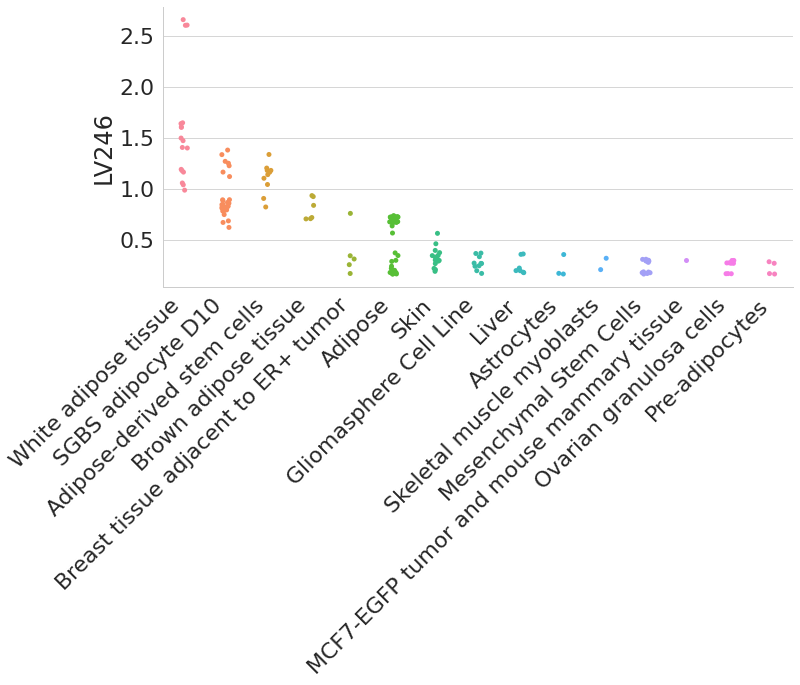

In [40]:
with sns.plotting_context("paper", font_scale=2.5), sns.axes_style("whitegrid"):
    g = sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTE,
        order=attr_order,
        kind="strip",
        height=5,
        aspect=2.5,
    )
    plt.xticks(rotation=45, horizontalalignment="right")
    plt.xlabel("")

    plt.savefig(
        OUTPUT_CELL_TYPE_FILEPATH,
        bbox_inches="tight",
        facecolor="white",
    )

# Debug

In [41]:
# with pd.option_context(
#     "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
# ):
#     _tmp = final_plot_data[final_plot_data[SELECTED_ATTRIBUTE].str.contains("ovarian")]
#     display(_tmp.head(20))

In [42]:
# # what is there in these projects?
# lv_data.loc[["SRP056041"]].dropna(how="all", axis=1).sort_values(
#     LV_NAME, ascending=False
# ).head(60)